<a href="https://colab.research.google.com/github/pranjalchaubey/Deep-Learning-Notes/blob/master/PyTorch%20Image%20Classification%20in%202020/Image_Classification_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using PyTorch in 2020  

In this notebook we will be utilizing some of the latest advancements in the  
[PyTorch Ecosystem](https://pytorch.org/ecosystem/) to build a simple image classifier using CNNs.   

Along the way, we will learn some PyTorch and CNN (Convolution Neural  
Networks) basics. 

### 1. Get the Dataset Onboard

In any Machine Learning/Data Science problem, the first step is always to get  
the dataset.  

In our case, to get things started, we will initially use the simple [MNIST Dataset](https://en.wikipedia.org/wiki/MNIST_database).  
MNIST is largely considered the _'Hello World!'_ of AI/ML. The dataset was  
created way back in the late 90s. The [official description](http://yann.lecun.com/exdb/mnist/) states,  

_"The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image._  

_It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting."_  

<br/>You might be wondering, how to get this dataset in our Colab Workspace?  
PyTorch comes with a _datasets_ module called, [Torchvision.Datasets](https://pytorch.org/docs/stable/torchvision/datasets.html).  
Torchvision.Datasets module contains a number of publically available datasets  
including the one we are looking for, MNIST. You are encouraged to explore the  
Torchvision.Datasets documentation page. 

In [0]:
# Lets import some libraries 
import torch # PyTorch 
from torchvision import datasets # Datasets module 
import torchvision.transforms as transforms # Image Transforms 
from torch.utils.data.sampler import SubsetRandomSampler # Sampler 

In [0]:
# The Data Science Regulars
import numpy as np 
import pandas as pd

Checking out the torchvision.datasets module documentation, we find  
![Torchvision.Dataset](https://drive.google.com/uc?id=1Zsgc5_PnO9BQQ5wqssf67A5Ge-qIXtLh)



In [0]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

### 2. Train Validation Test Split 

Once the download is complete (usually instantaneous), you should be able to  
see the MNIST dataset downloaded inside the _'data'_ folder on the left hand  
side. (Click on the _Files_ icon on the left sidebar)  

We have both the training and the test sets. Now we need to bifurcate the   
training set in two parts,  
1. Training Set (80% images)
2. Validation Set (20% images)  

The algorithm we use to do this is quite simple,  
1. Create a list of indices of the training data 
2. Randomly Shuffle those indices 
3. Slice the indices in 80-20 split 

[Why create a _Validation Set_ at all?](https://datascience.stackexchange.com/questions/18339/why-use-both-validation-set-and-test-set) 

In [50]:
# obtain training indices that will be used for validation

# 1. Create a list of indices of the training data  
num_train = len(train_data)
print('num_train = len(train_data) ==> ', num_train)
indices = list(range(num_train))
print('len(indices) ==>', len(indices))
# print(indices)

num_train = len(train_data) ==>  60000
len(indices) ==> 60000


In [0]:
# 2. Randomly Shuffle those indices
np.random.shuffle(indices)

In [52]:
# 3. Slice the indices in 80-20 split
# percentage of training set to use as validation
valid_size = 0.2 # ie Train Set divided into two parts 
                 # 80% Train 20% Validation 
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

print('len(train_idx) ==> ', len(train_idx))
print('len(valid_idx) ==> ', len(valid_idx))

len(train_idx) ==>  48000
len(valid_idx) ==>  12000


Please Note that so far we have just been fiddling around with the _'indices'_,  
not the actual images as such.....but Why?  
Answer below.  

### 3. Prepare the Dataloaders 

By now, we have downloaded the dataset, and created a train/valid/test split.  
Q: How do we _'push'_ this data into a PyTorch model?  
A: PyTorch has a mechanism to _'ingest'_ data from a dataset through a module  
known as `DataLoader`.  

A great analogy,  
![DataLoader](https://drive.google.com/uc?id=1U4IG-5lbFGQQS4xwQPU2QiYdR1hFGBZ5)

[Great tutorial on DataLoaders.](https://www.journaldev.com/36576/pytorch-dataloader)  
[Ultimate tutorial on DataLoaders.](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel) 

Time to prepare the _DataLoaders_ now!  

![DataLoader Documentation](https://drive.google.com/uc?id=1YFbWIGwNlL5Kp4Zvt52Ck0_Wk4MNfxS9)

In [0]:
# define samplers for obtaining training and validation batches
# remember train_idx and valid_idx were the indices that we shuffled above
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare dataloaders
# number of subprocesses to use for data loading
num_workers = 0 # do not modify 
# how many samples per batch to load
batch_size = 20 # ie 20 images per batch 

# Training Set 
train_loader = torch.utils.data.DataLoader(dataset=train_data, \
                                           batch_size=batch_size, \
                                           sampler=train_sampler, \
                                           num_workers=num_workers)
# Validation Set 
valid_loader = torch.utils.data.DataLoader(dataset=train_data, \
                                           batch_size=batch_size, \
                                           sampler=valid_sampler, \
                                           num_workers=num_workers)
# Test Set 
# Notice we have not used a 'sampler' here as it was not required 
test_loader = torch.utils.data.DataLoader(dataset=test_data, \
                                          batch_size=batch_size, \
                                          num_workers=num_workers)

We got the dataloaders working, but how do we know that they are working indeed?  
Visualizing the data from the dataloaders would be a good check! 

In [54]:
# Visualize a whole batch of data from the dataloaders 

dataiter = iter(train_loader) # Get the whole batch 
images, labels = dataiter.next() # Extract the images and their labels 
print(len(images), len(labels)) # Should be equal to the batch size, 20
print('Correct Labels: ', labels)
images = images.numpy() # Convert the images to numpy array for matplotlib
print('Shape of our images tensor =', images.shape)
print('Batch Size =', images.shape[0], 'Image Height/Width =', \
                                                        images.shape[2])

print()
print('Squeezing the images tensor =', np.squeeze(images).shape)
print('Un-squeezing the images tensor (axis=1) =', \
                                        np.expand_dims(images, axis=1).shape)

20 20
Correct Labels:  tensor([6, 5, 6, 3, 6, 0, 8, 4, 3, 7, 9, 8, 9, 0, 4, 8, 7, 6, 1, 1])
Shape of our images tensor = (20, 1, 28, 28)
Batch Size = 20 Image Height/Width = 28

Squeezing the images tensor = (20, 28, 28)
Un-squeezing the images tensor (axis=1) = (20, 1, 1, 28, 28)


In [0]:
import matplotlib.pyplot as plt 
# Plots are plotted inside the notebooks, 'inline'
%matplotlib inline 

With matplotlib, always remember that _figures contain axes which in turn   
contain the plots_.  
![Real Python](https://drive.google.com/uc?id=1KdlAGoCK8Lj9pFkrZf52oqOJK3sH3JuH)  

[Great tutorial on Matplotlib.](https://realpython.com/python-matplotlib-guide/)

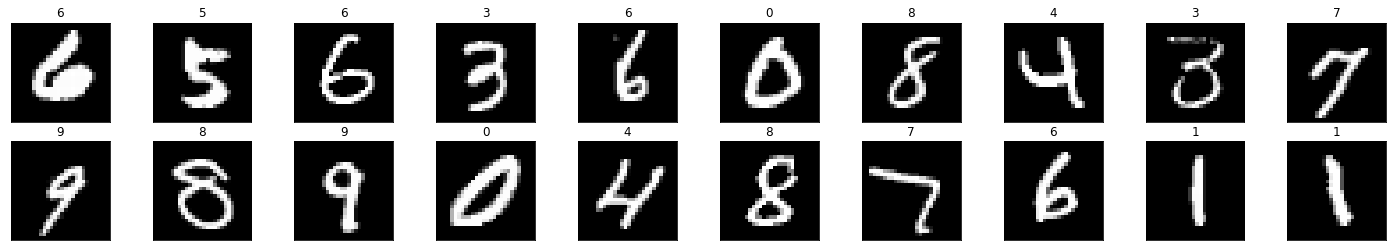

In [56]:
# Plot the whole batch 
fig = plt.figure(figsize=(25, 4))
# Loop over all the images in the batch(20)
for idx in np.arange(20):
    # Add a subplot for the image 
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    # Populate the subplot with the image 
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [92]:
# A neat little numpy trick
# Just for fun! 

dataiter = iter(train_loader)  
images, labels = dataiter.next() 
images = images.numpy() 
np.set_printoptions(precision=2, threshold=None, edgeitems=None, \
                    linewidth=180, suppress=None)
print('Label', labels[0])
print(images[0])

Label tensor(0)
[[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.32 0.84 0.99 0.32 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.16 0.95 0.99 0.99 0.8  0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.84 0.99 1.   0.99 1.   0.44 0.   0.   0.   0.

Our dataloaders seem to be working fine and out data looks great!  
<br/> 
Time to build our CNN based image classification model in PyTorch.....in 2020! 

### 4. Build a PyTorch CNN Model
But first, we need to know what are the components of a typical CNN based  
image classification architecture. 



| INSERT CNN INTRODUCTION | 

| INSERT PYTORCH INTRODUCTION | 

Time to define our model!  
But before we start off with the model definition, let's have a look at what  
the PyTorch Documentation says about the Convolutional NNs.  
![Conv2d Layer](https://drive.google.com/uc?id=1odHZIXURYjogjUcyCQ56RYfQPqgzO7DX "Conv2D")  

We also need to check out about the MaxPool, Dropout and Linear Layers.  

![MaxPool 2D](https://drive.google.com/uc?id=1r1EeLHrV5oAG4OUyRSm0lw2OcZyJQ7ne "MaxPool2D Layer")  

![Dropout Layer](https://drive.google.com/uc?id=1kYgb4wDrGEBEF5WB169N7Q5hTrwDDO1d "Dropout Layer")  

![Linear Layer](https://drive.google.com/uc?id=1rrIEqPtun_8Td1js76B2hv22Xm5tjY6m "Linear Layer")  

Did you guys notice a weird anomaly in the Conv2d and Linear layers?  
```
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
```  
```
torch.nn.Linear(in_features, out_features, bias=True)
```

Conv2d layer expects `in_channels` while the Linear layer expects `in_features`.  

Bottom line is, that PyTorch expects different things from a tensor dimension.  
Specifically,  
```
"""Example tensor size outputs, how PyTorch reads them, and where you encounter them in the wild. 
Note: the values below are only examples. Focus on the rank of the tensor (how many dimensions it has)."""
>>> torch.Size([32])
    # 1d: [batch_size] 
    # use for target labels or predictions.
>>> torch.Size([12, 256])
    # 2d: [batch_size, num_features (aka: C * H * W)]
    # use for as nn.Linear() input.
>>> torch.Size([10, 1, 2048])
    # 3d: [batch_size, channels, num_features (aka: H * W)]
    # when used as nn.Conv1d() input.
    # (but [seq_len, batch_size, num_features]
    # if feeding an RNN).
>>> torch.Size([16, 3, 28, 28])
    # 4d: [batch_size, channels, height, width]
    # use for as nn.Conv2d() input.
>>>  torch.Size([32, 1, 5, 15, 15])
    # 5D: [batch_size, channels, depth, height, width]
    # use for as nn.Conv3d() input.
```    

A neat method to make your tensors ready for the linear layer,  
```
Use view() to change your tensor’s dimensions.

image = image.view(batch_size, -1)

You supply your batch_size as the first number, and then “-1” basically tells Pytorch, “you figure out this other number for me… please.” 
Your tensor will now feed properly into any linear layer.
```

[Incredible Tutorial on PyTorch Layer Dimensions.](https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd)

Before we start,  
1. What is the shape (dimensions) of our images?  
2. What is the shape of our batches? 
3. How many _'channels'_ are there in our images? 

In [0]:
import torch.nn as nn # nn module contains all the layers 
import torch.nn.functional as F # same as nn, but a little different 

In [0]:
# Our CNN based neural architecture 
# Let's build a simple one with only Convolutional, Linear 
# and dropout layers
class MNISTModel1(nn.Module):
    # Here we define the neural architecture 
    def __init__(self):
        super(MNISTModel1, self).__init__() # Initialize the nn module 
        
        # Convolutional Layers
        # What shape/dimensions the first layer is going to see? 
        # Do we need to have some padding for a kernel_size = 3?  
        # Input Features = 1 x 28 x 28
        # Output Features = ???
        # Shape of a Convolutional Layer = (W - K + 2P)
        #                                  ------------ + 1
        #                                       S
        # where, 
        #       W = Width/Height of previous layer = 28
        #       K = Filter Size = 3
        #       P = Padding = 0
        #       S = Stride = 1(default)
        # Therefore, 
        #           if padding = 0
        #           Output Shape = ((28 - 3 + 2*0)/1)+1 = 26 
        # We want the dimensions to stay the same so that there is no 
        # loss of information when performing the convolution. 
        # Hence, 
        #       if padding = 1
        #       Output Shape = ((28 - 3 + 2*1)/1)+1 = 28
        # Output Features = 8 x 28 x 28  
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, \
                               stride=1, padding=1)
        # Input Features = 8 x 28 x 28
        # Output Features = 16 x 28 x 28 | ((28 - 3 + 2*1)/1)+1 = 28
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, \
                               stride=1, padding=1)

        # Linear Layers 
        # What shape the first linear layer is going see?
        # What are the total number of features given out by conv2?
        # Features = 16 x 28 x 28 = 12544
        # Therefore,           
        self.linear1 = nn.Linear(in_features=12544, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=64)
        # Last linear layer should output 10 features as we are 
        # Classifying the images in 10 categories 
        self.linear3 = nn.Linear(in_features=64, out_features=10)

        # Dropout 
        self.dropout = nn.Dropout(p=0.25)

    # Here we define the 'forward behaviour' of our neural architecture 
    def forward(self, image_batch):
        # This is also the place where we add ACTIVATION functions 
        image_batch = F.relu(input=self.conv1(image_batch))          
        image_batch = F.relu(input=self.conv2(image_batch))  
        
        # Remember that when passing image_batch through the Linear layers, 
        # PyTorch expects: 
        # >>> torch.Size([12, 256]) -> example values 
            # 2d: [batch_size, num_features (aka: C * H * W)]
            # use for nn.Linear() input.   
        # Therefore, we need to 'flatten' image_batch
        # image_batch = image_batch.view(batch_size, -1) --> batch size ???
        flat_image_batch = image_batch.view(image_batch.shape[0], -1)
        flat_image_batch = F.relu(input=self.linear1(flat_image_batch))
        # Let's add the dropout too 
        flat_image_batch = self.dropout(F.relu(input=self.linear2(flat_image_batch)))
        # Final Layer of the network 
        flat_image_batch = F.relu(input=self.linear3(flat_image_batch))
        # The output from the final layer is a tensor with 10 'logits'
        return flat_image_batch               

Now that we have defined our model, is there a way we can peep inside to see  
what is going on and that if everything is alright?  

Guess it's time to install _**[torchsummary !!!](https://github.com/sksq96/pytorch-summary)**_ 

In [60]:
# Let's install torchsummary and do some cool stuff 
!pip install torchsummary # https://github.com/sksq96/pytorch-summary 

In [0]:
# Let's import some cool functions from these libraries 
# from poutyne.framework import Model # The core datastructure of poutyne 
# from poutyne.framework import ModelCheckpoint # Saves trained model during training
# from poutyne.framework import Callback # We will see it in action in a little while 

from torchsummary import summary 

In [62]:
# We can make the use of torchsummary library here to figure 
# if we have done something wrong 

# But first we need to tell PyTorch where to 'keep' the model 
# On GPU or on CPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('The model will run on', device)

# Initialize the model 
mnist1 = MNISTModel1().to(device)
summary(model=mnist1, input_size=(1, 28, 28), batch_size=20) # Summarize

The model will run on cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [20, 8, 28, 28]              80
            Conv2d-2           [20, 16, 28, 28]           1,168
            Linear-3                  [20, 256]       3,211,520
            Linear-4                   [20, 64]          16,448
           Dropout-5                   [20, 64]               0
            Linear-6                   [20, 10]             650
Total params: 3,229,866
Trainable params: 3,229,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 2.93
Params size (MB): 12.32
Estimated Total Size (MB): 15.31
----------------------------------------------------------------


That was a lot of work.....Whew!  

_***Q: Isn't there an 'easier' way to define the Model in 2020?***_  
A: _**Yes, absolutely!**_  
Say hello to the _**[torchlayers library !!!](https://github.com/szymonmaszke/torchlayers)**_  
With torchlayers, the above code will be reduced to about 7-8 lines!  
But unfortunately, [torchlayers requires Python 3.7](https://github.com/szymonmaszke/torchlayers/issues/5) and above. Colab only  
supports Python 3.6.x. 



With our model definition complete, it is time to train! 

### 5. Train a PyTorch Model in 2020  

PyTorch is infamous among newcomers for it's _'training loops'_.  
They can be long and at times a little confusing too. However, most of them   
are similar and writing training loops simply turns out to be a boring and repetitive  
exercise.  

Q: _**This is 2020.**_ Is there a better way?  
A: _**Yes, absolutely!**_  
Say hello to _**[Poutyne !!!](https://poutyne.org/index.html)**_   


Thanks to _Poutyne_, writing training loops in PyTorch is _**FUN !!!**_  

PS - Poutyne is pronounced as Poutine or Pu-tin.  
![Poutyne](https://drive.google.com/uc?id=142xYy_mJoPSk97SDicvn9zRNxHMpXDxz "You think loops are boring?!?!")

In [63]:
# Install Poutyne 
!pip install poutyne 

In [0]:
# Import some useful functions from the Poutybne library 
from poutyne.framework import Model # The core datastructure of poutyne 
                                    # https://poutyne.org/model.html
from poutyne.framework import ModelCheckpoint # Saves trained model during training
                                              # https://poutyne.org/callbacks.html#checkpointing
from poutyne.framework import Callback # We will see it in action in a little while 
                                       # https://poutyne.org/callbacks.html# 

In [0]:
from torch import optim # Optimizer: we need it to train our network

In [0]:
# A pouytne training loop

# A few hyperparamters for the training loop 
learning_rate = 0.1
epochs = 1

def poutyne_train(pytorch_network):
    
    # Select the optimizer and the loss function 
    optimizer = optim.SGD(pytorch_network.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    # Poutyne Model
    model = Model(pytorch_network, optimizer, loss_function, batch_metrics=['accuracy'])
    # Send the 'Poutyne model' on GPU/CPU whichever is available 
    model.to(device)
    # Train
    model.fit_generator(train_loader, valid_loader, epochs=epochs)
    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print(f'Test:\n\tLoss: {test_loss: .3f}\n\tAccuracy: {test_acc: .3f}')

In [81]:
# Let's start the training guys!!! 
poutyne_train(mnist1)

Epoch 1/1 83.49s Step 2400/2400: loss: 0.023527, acc: 99.262500, val_loss: 0.070297, val_acc: 98.225000
Test:
	Loss:  0.059
	Accuracy:  98.510


_**CONGRATULATIONS !!! You just trained your first(?) CNN Model!**_   
The accuracy looks pretty decent as well! 


### 6. Understanding Overfitting 

However, we are not done yet.  
When we are training large deep learning models on massive datasets, the  
training can take days and sometimes, [even weeks!](https://ai.googleblog.com/2016/03/train-your-own-image-classifier-with.html "2 Weeks to train Inception v3!")  

When training on such large datasets, we need to make sure that we are saving   
our best model as and when it gets trained after every epoch, lest something   
gets awry and we lose days/weeks worth of training (and a lot of money  
spent on the electricity!). 

Before we move any further we need to understand the concept of _**Overfitting**_  
in Machine Learning models.  
What is _**overfitting?**_  
![Fitting Examples](https://drive.google.com/uc?id=1gFOa5I24S7XDDep4WaVMIoivh9JvIp1Y "https://www.curiousily.com/posts/hackers-guide-to-fixing-underfitting-and-overfitting-models/")

We are always looking to ensure that our models have a low bias with a low  
variance.  
However, if we train for too long (too many epochs) our model will start to  
overfit.  

How do we identify that the model has started overfitting?  
![Overfitting](https://drive.google.com/uc?id=1q02q0ge0jldHJm8P_Hq6ECeIvaSlcc36 "https://mlexplained.com/2018/04/24/overfitting-isnt-simple-overfitting-re-explained-with-priors-biases-and-no-free-lunch/")  
Dotted vertical line is where we should either stop training the model (also  
known as _**Early Stopping**_) or we should have some logic in the training  
loop that _'saves'_ the model around that time while the training still  
continues. 

Our model will also overfit if it is too complex.  
For example (y-axis is different),  
![Complex Model](https://drive.google.com/uc?id=1vWHgknPrbXEQczdKMliB0RyVgYld3cGa "https://medium.com/@george.drakos62/cross-validation-70289113a072")  

<br/>Early stopping can save the day!  
![alt text](https://drive.google.com/uc?id=1HnBFMWZGHy0UFMUICKU25qBiB-4_G0Xn "https://www.jeremyjordan.me/deep-neural-networks-preventing-overfitting/")

A really nice matrix to identify if we are overfitting:  
![Overfitting Matrix](https://drive.google.com/uc?id=19bFHepjNgQ9kpqmQdMEW4lDJ-qXi5WF8 "https://hackernoon.com/memorizing-is-not-learning-6-tricks-to-prevent-overfitting-in-machine-learning-820b091dc42")  
While preparing the above matrix, the author has considered only two sets,  
training and testing (kinda _faux pass_!). Since we have a validation set as  
well, replace the word _**'Testing'**_ with _**'Validation'**_. 

How can we avoid _**Overfitting**_?  
1. Use a simpler model (less layers)  
2. Use _Dropout_ 
3. Get more training data (if possible) 
4. Augment the data and add noise  
5. Early Stopping  

PS - Not an exhaustive list AT ALL.  

<br/>Can we write a better training loop now? 